Site [1] to portal do HyCOM que descreve as diversas implementações do modelo ao longo dos anos:

O Acesso por THREDDS/OPeNDAP ou ftp é super lento e falha bastante. Nossa melhor chance é pegar por https mesmo de [2]. De acordo com [1] o `GLBy0.08` dessa URL é: _grid is 0.08 deg lon x 0.04 deg lat that covers 80S to 90N._

Os arquivos são nomeados no formato "`hycon_grade_experimento_data_hora_campo`", por exemplo `hycom_GLBy0.08_930_2019010112_t000_sur.nc`. Os campos ice, ssh, sur, ts3z, uv3z são descritos em [1].

[1] https://www.hycom.org/dataserver/gofs-3pt1/analysis
[2] https://data.hycom.org/datasets/GLBy0.08/expt_93.0/data/hindcasts/2019

Os arquivos são muito grandes, o `sur` por exemplo tem ~500 MB para cada hora! Por isso é necessário definir bem os limites do espaço-tempo e campos necessário para a simulação. Infelizemnte isso seria mais fácil pelo THREDDS mas o serviddor deles não funciona bem. Então teremos que pegar os arquivos um-a-um e recortar a área de interesse. Aqui vai um exemplo pegando um arquivo "sur" (surface/diagnostic Fields/Variables) e checar a velocidade barotrópica.

In [1]:
from pathlib import Path


uri = "https://data.hycom.org/datasets"
grid_version = "GLBy0.08"
exp = "expt_93.0"
mtype = "hindcasts"  # There are also forecasts.
year = 2019

fname = "hycom_GLBy0.08_930_2019010112_t000_sur.nc"

url = f"{uri}/{grid_version}/{exp}/data/{mtype}/{year}/{fname}"

if not Path(fname).is_file():
    !wget $url
else:
    print(f"File {fname} already exits.")

File hycom_GLBy0.08_930_2019010112_t000_sur.nc already exits.


In [2]:
import xarray as xr


ds = xr.open_dataset("hycom_GLBy0.08_930_2019010112_t000_sur.nc", decode_times=False)

# longitudes no HyCOM são de 0-360, vamos converter para -180–180
ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))

xarray cannot deal with hindcast times but all files are 1-hour only and the date-time is coded in the filename too. Here we are 2019-01-01 12:00:00, and the file name has 2019010112 as well.

In [3]:
import cftime


cftime.num2date(
    times=ds["time"],
    units=ds["time"].units,
    calendar=ds["time"].calendar,
).squeeze()

array(cftime.DatetimeGregorian(2019, 1, 1, 12, 0, 0, 0, has_year_zero=False),
      dtype=object)

In [4]:
min_time, max_time = "2016-12-06", "2019-12-06"

min_lat, max_lat = -33, -24
min_lon, max_lon = -53, -44

In [5]:
mask_lon = (ds.lon >= min_lon) & (ds.lon <= max_lon)
mask_lat = (ds.lat >= min_lat) & (ds.lat <= max_lat)

subset = ds.where(mask_lon & mask_lat, drop=True).squeeze()

In [6]:
u = subset["u_barotropic_velocity"]
v = subset["v_barotropic_velocity"]

In [7]:
import numpy as np


u_norm = u / np.sqrt(u ** 2.0 + v ** 2.0)
v_norm = v / np.sqrt(u ** 2.0 + v ** 2.0)

speed = (u ** 2 + v ** 2) ** 0.5

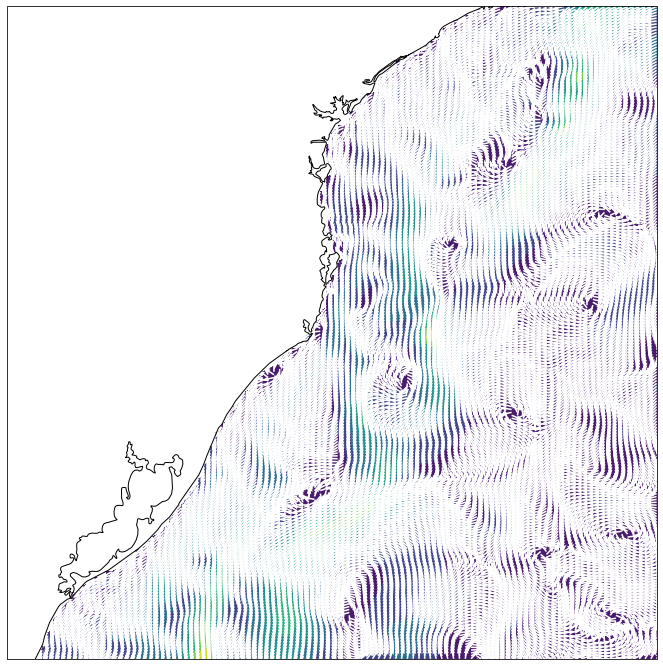

In [8]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


fig, ax = plt.subplots(
    figsize=(12, 12),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    }
)

ax.contourf(subset["lon"], subset["lat"], speed)
ax.quiver(subset["lon"], subset["lat"], u_norm, v_norm, color="white", scale=50)
ax.coastlines(resolution="10m");